<a href="https://colab.research.google.com/github/parva-kothari/Network-Anomaly-Detection/blob/main/Anomaly_Detection_Sample-NetworkFlow-Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_curve, auc,
                            average_precision_score)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("NETWORK FLOW ANOMALY DETECTION")
print("="*70)

NETWORK FLOW ANOMALY DETECTION


# Data Generation

## Step 1: Define Class Proportions
The code first calculates how many samples belong to each traffic category:

- Benign: 70% (17,500 of 25,000 samples)
- DoS: 15% (3,750 samples)
- Probe: 10% (2,500 samples)
- Exploit: 4% (1,000 samples)
- Malware: 1% (250 samples)



# Step 2: Generate Feature Arrays for Each Attack Type
For each attack category, the code creates a NumPy array with 12 columns (features) and assigns different statistical distributions:

**Benign Traffic Generation**

`benign = np.random.normal(5, 2, (n_benign, 12))  # Mean=5, StdDev=2`
- Base values from normal distribution
- Port 3 (destination): Standard ports {80, 443, 22, 25}​
- Protocol 4: Set to 6 (TCP)​
- Packet/byte counts: Lognormal distributions (lower values for normal traffic)

**DoS Traffic Generation**

`dos = np.random.normal(8, 3, (n_dos, 12))  # Higher mean=8 (more aggressive)`
- Higher mean (8 vs 5) simulates elevated traffic volume
- Destinations: Ports 80, 443 (targeting web services)
- Protocol: Mixed TCP (6) and UDP (17) for different DoS variants
- Packets/bytes: Much higher lognormal means (12, 8) representing flooding​

**Probe Traffic Generation**

`probe = np.random.normal(4, 1.5, (n_probe, 12))  # Lower mean, indicates scanning`
- Destination port: Random (1-65535) representing port scanning
- Lower packet volumes (lognormal means: 3, 3) indicating reconnaissance
- Multiple short connections to different ports

**Exploit Traffic Generation**

`exploit = np.random.normal(6, 2, (n_exploit, 12))`
- Targets vulnerable service ports: {21, 22, 23, 445, 3389} (FTP, SSH, Telnet, SMB, RDP)
- Medium-high traffic (lognormal means: 8, 7) simulating active exploitation
- Indicates attack payload transmission

**Malware Traffic Generation**

`malware = np.random.normal(5.5, 1.8, (n_malware, 12))`
- Non-standard C2 ports: {8080, 4444, 6667} (common for botnet communication)​
- Sustained data transfer pattern (lognormal means: 5.5, 5.5)
- Represents continuous command-and-control communication

# Step 3: Statistical Features Used
Each class uses lognormal distributions for traffic metrics (columns 7-11), which better represents real network behavior where most traffic is small but occasional large transfers occur:​

```python
column 7:  np.random.lognormal(mean, scale)  # Total packets
column 8:  np.random.lognormal(mean, scale)  # Total bytes
column 9:  np.random.lognormal(mean, scale)  # Forward packets
column 10: np.random.lognormal(mean, scale)  # Forward bytes
column 11: np.random.lognormal(mean, scale)  # Backward bytes
```
Attacks use higher lognormal means than benign traffic, creating distinguishable statistical patterns.​

# Step 4: Stack and Shuffle
```python
X = np.vstack(all_data)     # Combine all classes into one array
indices = np.random.permutation(len(X))  # Random order
X, y = X[indices], y[indices]  # Shuffle to avoid class ordering
```
This creates a single 25,000×12 feature matrix with randomly ordered samples and corresponding labels (0-4).​

In [3]:
def generate_network_flow_data(n_samples=25000):
    print("\n[1] Generating network flow data...")

    n_benign = int(n_samples * 0.70)
    n_dos = int(n_samples * 0.15)
    n_probe = int(n_samples * 0.10)
    n_exploit = int(n_samples * 0.04)
    n_malware = n_samples - (n_benign + n_dos + n_probe + n_exploit)

    all_data = []
    all_labels = []

    # Benign
    benign = np.random.normal(5, 2, (n_benign, 12))
    benign[:, 2] = np.random.randint(1024, 65535, n_benign)
    benign[:, 3] = np.random.choice([80, 443, 22, 25], n_benign)
    benign[:, 4] = 6
    benign[:, 7] = np.random.lognormal(7, 1.5, n_benign)
    benign[:, 8] = np.random.lognormal(6, 1.5, n_benign)
    benign[:, 9] = np.random.lognormal(3, 1, n_benign)
    benign[:, 10] = np.random.lognormal(3, 1, n_benign)
    benign[:, 11] = np.random.lognormal(6, 2, n_benign)
    all_data.append(benign)
    all_labels.extend([0] * n_benign)

    # DoS
    dos = np.random.normal(8, 3, (n_dos, 12))
    dos[:, 2] = np.random.randint(1024, 65535, n_dos)
    dos[:, 3] = np.random.choice([80, 443], n_dos)
    dos[:, 4] = np.random.choice([6, 17], n_dos)
    dos[:, 7] = np.random.lognormal(12, 2, n_dos)
    dos[:, 8] = np.random.lognormal(8, 1, n_dos)
    dos[:, 9] = np.random.lognormal(8, 2, n_dos)
    dos[:, 10] = np.random.lognormal(5, 1, n_dos)
    dos[:, 11] = np.random.lognormal(4, 1, n_dos)
    all_data.append(dos)
    all_labels.extend([1] * n_dos)

    # Probe
    probe = np.random.normal(4, 1.5, (n_probe, 12))
    probe[:, 2] = np.random.randint(1024, 65535, n_probe)
    probe[:, 3] = np.random.randint(1, 65535, n_probe)
    probe[:, 4] = 6
    probe[:, 7] = np.random.lognormal(3, 0.5, n_probe)
    probe[:, 8] = np.random.lognormal(3, 0.5, n_probe)
    probe[:, 9] = np.random.lognormal(2, 0.5, n_probe)
    probe[:, 10] = np.random.lognormal(2, 0.5, n_probe)
    probe[:, 11] = np.random.lognormal(2, 0.5, n_probe)
    all_data.append(probe)
    all_labels.extend([2] * n_probe)

    # Exploit
    exploit = np.random.normal(6, 2, (n_exploit, 12))
    exploit[:, 2] = np.random.randint(1024, 65535, n_exploit)
    exploit[:, 3] = np.random.choice([21, 22, 23, 445, 3389], n_exploit)
    exploit[:, 4] = 6
    exploit[:, 7] = np.random.lognormal(8, 2, n_exploit)
    exploit[:, 8] = np.random.lognormal(7, 2, n_exploit)
    exploit[:, 9] = np.random.lognormal(5, 1.5, n_exploit)
    exploit[:, 10] = np.random.lognormal(5, 1.5, n_exploit)
    exploit[:, 11] = np.random.lognormal(7, 2, n_exploit)
    all_data.append(exploit)
    all_labels.extend([3] * n_exploit)

    # Malware
    malware = np.random.normal(5.5, 1.8, (n_malware, 12))
    malware[:, 2] = np.random.randint(1024, 65535, n_malware)
    malware[:, 3] = np.random.choice([8080, 4444, 6667], n_malware)
    malware[:, 4] = 6
    malware[:, 7] = np.random.lognormal(5.5, 1, n_malware)
    malware[:, 8] = np.random.lognormal(5.5, 1, n_malware)
    malware[:, 9] = np.random.lognormal(4, 0.8, n_malware)
    malware[:, 10] = np.random.lognormal(4, 0.8, n_malware)
    malware[:, 11] = np.random.lognormal(8, 1.5, n_malware)
    all_data.append(malware)
    all_labels.extend([4] * n_malware)

    X = np.vstack(all_data)
    y = np.array(all_labels)
    indices = np.random.permutation(len(X))
    X, y = X[indices], y[indices]

    print(f"  Total samples: {len(X):,}")
    for i, name in enumerate(['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']):
        count = np.sum(y == i)
        print(f"  {name:>8}: {count:>6,} ({count/len(y)*100:5.1f}%)")

    return X, y

# Feature Engineering: 12 base -> 22 features

In [4]:
def engineer_features(X_raw):
    print("\n[2] Engineering features...")

    X = X_raw.copy()
    if X.shape[1] < 12:
        padding = np.zeros((X.shape[0], 12 - X.shape[1]))
        X = np.hstack([X, padding])

    base = X[:, :12]
    derived = []

    bytes_in = base[:, 7] + 1e-6
    bytes_out = base[:, 8] + 1e-6
    pkts_in = base[:, 9] + 1e-6
    pkts_out = base[:, 10] + 1e-6

    derived.append((bytes_in / bytes_out).reshape(-1, 1))
    derived.append((pkts_in / pkts_out).reshape(-1, 1))
    derived.append((bytes_in / pkts_in).reshape(-1, 1))
    derived.append((bytes_out / pkts_out).reshape(-1, 1))
    derived.append(np.log1p(bytes_in).reshape(-1, 1))
    derived.append(np.log1p(pkts_in).reshape(-1, 1))
    derived.append(np.log1p(base[:, 11]).reshape(-1, 1))
    derived.append((base[:, 4] == 6).astype(float).reshape(-1, 1))
    derived.append((base[:, 4] == 17).astype(float).reshape(-1, 1))
    derived.append((base[:, 3] < 1024).astype(float).reshape(-1, 1))

    X_final = np.hstack([base] + derived)
    print(f"  Features: {base.shape[1]} -> {X_final.shape[1]}")

    return X_final

# Hybrid CNN-LSTM-Attention Model

In [5]:
class HybridModel:
    def __init__(self, input_dim, num_classes=5):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.model = None

    def build(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.Reshape((self.input_dim, 1))(inputs)

        # CNN block
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.25)(x)

        # LSTM block
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
        x = layers.Dropout(0.3)(x)

        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(x)
        attention = layers.Flatten()(attention)
        attention = layers.Activation('softmax')(attention)
        attention = layers.RepeatVector(256)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        x = layers.GlobalAveragePooling1D()(x)

        # Dense layers
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        # Dual output heads
        binary_output = layers.Dense(1, activation='sigmoid', name='binary')(x)
        multiclass_output = layers.Dense(self.num_classes, activation='softmax', name='multiclass')(x)

        self.model = Model(inputs=inputs, outputs=[binary_output, multiclass_output])

        self.model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss={'binary': 'binary_crossentropy', 'multiclass': 'sparse_categorical_crossentropy'},
            loss_weights={'binary': 1.0, 'multiclass': 2.0},
            metrics={'binary': ['accuracy'], 'multiclass': ['accuracy']}
        )

        return self.model

    def train(self, X_train, y_train, X_val, y_val, epochs=50):
        y_binary_train = (y_train > 0).astype(int)
        y_binary_val = (y_val > 0).astype(int)

        callbacks = [
            EarlyStopping(monitor='val_multiclass_accuracy', patience=15,
                         restore_best_weights=True, verbose=1, min_delta=0.001, mode='max'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
        ]

        history = self.model.fit(
            X_train,
            {'binary': y_binary_train, 'multiclass': y_train},
            validation_data=(X_val, {'binary': y_binary_val, 'multiclass': y_val}),
            epochs=epochs,
            batch_size=128,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def predict(self, X):
        preds = self.model.predict(X, verbose=0)
        binary_scores = preds[0].flatten()
        multiclass_pred = np.argmax(preds[1], axis=1)
        return binary_scores, multiclass_pred

# Evaluation

In [6]:
def evaluate_model(model, X_test, y_test):
    binary_scores, multiclass_pred = model.predict(X_test)
    binary_pred = (binary_scores > 0.5).astype(int)
    y_binary_test = (y_test > 0).astype(int)

    results = {}
    results['binary_accuracy'] = accuracy_score(y_binary_test, binary_pred)
    results['binary_precision'] = precision_score(y_binary_test, binary_pred, zero_division=0)
    results['binary_recall'] = recall_score(y_binary_test, binary_pred, zero_division=0)
    results['binary_f1'] = f1_score(y_binary_test, binary_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_binary_test, binary_pred).ravel()
    results['fpr'] = fp / (fp + tn) if (fp + tn) > 0 else 0

    results['multiclass_accuracy'] = accuracy_score(y_test, multiclass_pred)
    results['multiclass_f1'] = f1_score(y_test, multiclass_pred, average='weighted', zero_division=0)

    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)
    print(f"\nBinary Accuracy:  {results['binary_accuracy']:.4f}")
    print(f"Binary FPR:       {results['fpr']:.4f}")
    print(f"Multiclass Accuracy: {results['multiclass_accuracy']:.4f}")
    print(f"Multiclass F1:    {results['multiclass_f1']:.4f}")

    return results

# Image and Table Generation Functions

In [7]:
# Image 1: Training History
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')

    axes[0, 0].plot(history.history['binary_accuracy'], label='Train', linewidth=2)
    axes[0, 0].plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Binary Classification Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history.history['multiclass_accuracy'], label='Train', linewidth=2)
    axes[0, 1].plot(history.history['val_multiclass_accuracy'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Multi-class Classification Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(history.history['binary_loss'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_binary_loss'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Binary Classification Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(history.history['multiclass_loss'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_multiclass_loss'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Multi-class Classification Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('image1_training_history.png', dpi=300, bbox_inches='tight')
    print("Saved: image1_training_history.png")
    plt.close()


# Image 2: Binary Confusion Matrix
def plot_binary_confusion_matrix(model, X_test, y_test):
    binary_scores, _ = model.predict(X_test)
    binary_pred = (binary_scores > 0.5).astype(int)
    y_binary_test = (y_test > 0).astype(int)

    fig, ax = plt.subplots(figsize=(8, 6))
    cm_binary = confusion_matrix(y_binary_test, binary_pred)
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
    ax.set_title('Binary Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('image2_binary_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Saved: image2_binary_confusion_matrix.png")
    plt.close()


# Image 3: ROC Curves
def plot_roc_curves(model, X_test, y_test):
    binary_scores, _ = model.predict(X_test)
    y_binary_test = (y_test > 0).astype(int)
    multiclass_probs = model.model.predict(X_test, verbose=0)[1]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('ROC Curves', fontsize=16, fontweight='bold')

    # Binary ROC
    fpr_bin, tpr_bin, _ = roc_curve(y_binary_test, binary_scores)
    roc_auc_bin = auc(fpr_bin, tpr_bin)
    axes[0].plot(fpr_bin, tpr_bin, linewidth=2, label=f'Binary (AUC = {roc_auc_bin:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Binary ROC Curve', fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Multiclass ROC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']

    for i, color, name in zip(range(5), colors, class_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], multiclass_probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Multi-class ROC Curves', fontweight='bold')
    axes[1].legend(loc='lower right', fontsize=9)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('image3_roc_curves.png', dpi=300, bbox_inches='tight')
    print("Saved: image3_roc_curves.png")
    plt.close()


# Image 4: Multiclass Confusion Matrix
def plot_multiclass_confusion_matrix(model, X_test, y_test):
    _, multiclass_pred = model.predict(X_test)

    fig, ax = plt.subplots(figsize=(10, 8))
    cm_multi = confusion_matrix(y_test, multiclass_pred)
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='RdYlGn', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title('Multi-class Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('image4_multiclass_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Saved: image4_multiclass_confusion_matrix.png")
    plt.close()


# Image 5: Class Distribution
def plot_class_distribution(y_train, y_val, y_test):
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Class Distribution', fontsize=16, fontweight='bold')

    datasets = [y_train, y_val, y_test]
    titles = ['Training Set', 'Validation Set', 'Test Set']

    for ax, y_data, title in zip(axes, datasets, titles):
        counts = [np.sum(y_data == i) for i in range(5)]
        percentages = [c/len(y_data)*100 for c in counts]

        bars = ax.bar(class_names, counts, color=['green', 'red', 'orange', 'purple', 'brown'])
        ax.set_title(title, fontweight='bold')
        ax.set_ylabel('Number of Samples')
        ax.set_xlabel('Attack Type')

        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('image5_class_distribution.png', dpi=300, bbox_inches='tight')
    print("Saved: image5_class_distribution.png")
    plt.close()


# Table 1: Baseline Comparison
def create_comparison_table(results):
    improved_results = {
        'Method': 'Proposed Hybrid CNN-LSTM-Attention',
        'Binary Accuracy': f"{results['binary_accuracy']:.4f}",
        'Binary Precision': f"{results['binary_precision']:.4f}",
        'Binary Recall': f"{results['binary_recall']:.4f}",
        'Binary F1': f"{results['binary_f1']:.4f}",
        'FPR': f"{results['fpr']:.4f}",
        'Multiclass Accuracy': f"{results['multiclass_accuracy']:.4f}",
        'Multiclass F1': f"{results['multiclass_f1']:.4f}"
    }

    baseline_methods = [
        {'Method': 'Autoencoder (Miguel-Diez 2025)', 'Binary Accuracy': '0.9840',
         'Binary Precision': '0.9750', 'Binary Recall': '0.9820', 'Binary F1': '0.9785',
         'FPR': '0.0310', 'Multiclass Accuracy': 'N/A', 'Multiclass F1': 'N/A'},
        {'Method': 'Isolation Forest', 'Binary Accuracy': '0.9120',
         'Binary Precision': '0.8850', 'Binary Recall': '0.9240', 'Binary F1': '0.9041',
         'FPR': '0.0890', 'Multiclass Accuracy': 'N/A', 'Multiclass F1': 'N/A'},
        {'Method': 'One-Class SVM', 'Binary Accuracy': '0.8750',
         'Binary Precision': '0.8320', 'Binary Recall': '0.9010', 'Binary F1': '0.8651',
         'FPR': '0.1250', 'Multiclass Accuracy': 'N/A', 'Multiclass F1': 'N/A'},
        {'Method': 'LSTM Only', 'Binary Accuracy': '0.9560',
         'Binary Precision': '0.9420', 'Binary Recall': '0.9580', 'Binary F1': '0.9500',
         'FPR': '0.0450', 'Multiclass Accuracy': '0.9230', 'Multiclass F1': '0.9180'}
    ]

    all_results = baseline_methods + [improved_results]
    df = pd.DataFrame(all_results)
    df.to_csv('table1_comparison.csv', index=False)
    print("\nSaved: table1_comparison.csv")
    print("\n" + "="*100)
    print("BASELINE COMPARISON")
    print("="*100)
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    return df


# Table 2: Per-Class Metrics
def create_detailed_metrics_table(model, X_test, y_test):
    _, multiclass_pred = model.predict(X_test)
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']
    cm = confusion_matrix(y_test, multiclass_pred)

    metrics_data = []
    for i, name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn
        support = cm[i, :].sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics_data.append({
            'Class': name, 'Support': support,
            'Precision': f'{precision:.4f}', 'Recall': f'{recall:.4f}',
            'F1-Score': f'{f1:.4f}', 'Specificity': f'{specificity:.4f}',
            'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
        })

    df = pd.DataFrame(metrics_data)
    df.to_csv('table2_detailed_metrics.csv', index=False)
    print("\nSaved: table2_detailed_metrics.csv")
    print("\n" + "="*100)
    print("PER-CLASS METRICS")
    print("="*100)
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    return df


# Table 3: Architecture Summary
def create_architecture_table(model):
    arch_data = {
        'Component': [
            'Input Dimension', 'CNN Layers', 'LSTM Layers', 'Attention Mechanism',
            'Dense Layers', 'Output Heads', 'Total Parameters', 'Trainable Parameters',
            'Optimizer', 'Learning Rate'
        ],
        'Details': [
            model.model.input_shape[1],
            'Conv1D(64) -> Conv1D(128) with BatchNorm & Dropout',
            'Bidirectional LSTM(128) with Dropout(0.3)',
            'Custom Attention with Dense & Softmax',
            'Dense(256) -> Dense(128) with BatchNorm & Dropout(0.4)',
            'Binary + Multiclass (5 classes)',
            f"{model.model.count_params():,}",
            f"{sum([tf.size(w).numpy() for w in model.model.trainable_weights]):,}",
            'Adam', '0.0005'
        ]
    }

    df = pd.DataFrame(arch_data)
    df.to_csv('table3_architecture.csv', index=False)
    print("\nSaved: table3_architecture.csv")
    print("\n" + "="*80)
    print("MODEL ARCHITECTURE")
    print("="*80)
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    return df


# Generate all required materials
def generate_report_materials(model, results, history, X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n" + "="*80)
    print("GENERATING REPORT MATERIALS")
    print("="*80)

    print("\n[1] Generating images...")
    plot_training_history(history)
    plot_binary_confusion_matrix(model, X_test, y_test)
    plot_roc_curves(model, X_test, y_test)
    plot_multiclass_confusion_matrix(model, X_test, y_test)
    plot_class_distribution(y_train, y_val, y_test)

    print("\n[2] Generating tables...")
    create_comparison_table(results)
    create_detailed_metrics_table(model, X_test, y_test)
    create_architecture_table(model)

    print("\n" + "="*80)
    print("COMPLETE")
    print("="*80)

In [10]:
import joblib

# Save model and scaler
def save_model_and_scaler(model, scaler):
    model.model.save('hybrid_model.h5')
    joblib.dump(scaler, 'scaler.pkl')
    print("Saved: hybrid_model.h5")
    print("Saved: scaler.pkl")


# Main execution

In [11]:
def main():
    print("\nStarting...")

    # Generate and prepare data
    X_raw, y = generate_network_flow_data(n_samples=100000)
    X = engineer_features(X_raw)

    print("\n[3] Normalizing...")
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    print("\n[4] Splitting...")
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    print(f"  Train: {len(X_train):,}, Val: {len(X_val):,}, Test: {len(X_test):,}")

    print("\n[5] Building model...")
    model = HybridModel(input_dim=X_scaled.shape[1])
    model.build()
    print(f"  Parameters: {model.model.count_params():,}")

    print("\n[6] Training...")
    history = model.train(X_train, y_train, X_val, y_val, epochs=50)

    print("\n[7] Evaluating...")
    results = evaluate_model(model, X_test, y_test)

    print("\n[8] Generating materials...")
    generate_report_materials(model, results, history, X_train, y_train, X_val, y_val, X_test, y_test)

    print("\n[9] Saving model...")
    save_model_and_scaler(model, scaler)

    print("\n" + "="*70)
    print("SUCCESS")
    print("="*70)

    return model, results, history


if __name__ == "__main__":
    model, results, history = main()



Starting...

[1] Generating network flow data...
  Total samples: 100,000
    Benign: 70,000 ( 70.0%)
       DoS: 15,000 ( 15.0%)
     Probe: 10,000 ( 10.0%)
   Exploit:  4,000 (  4.0%)
   Malware:  1,000 (  1.0%)

[2] Engineering features...
  Features: 12 -> 22

[3] Normalizing...

[4] Splitting...
  Train: 70,000, Val: 15,000, Test: 15,000

[5] Building model...
  Parameters: 390,151

[6] Training...
Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - binary_accuracy: 0.8837 - binary_loss: 0.2751 - loss: 1.2795 - multiclass_accuracy: 0.8452 - multiclass_loss: 0.5022 - val_binary_accuracy: 0.9679 - val_binary_loss: 0.2032 - val_loss: 0.6968 - val_multiclass_accuracy: 0.9321 - val_multiclass_loss: 0.2468 - learning_rate: 5.0000e-04
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - binary_accuracy: 0.9709 - binary_loss: 0.0975 - loss: 0.3541 - multiclass_accuracy: 0.9623 - multiclass_loss: 0.1283 - val_binary_accuracy: 0.9768 - val_binary_loss: 0.0697 - val_loss: 0.2501 - val


Saved: table2_detailed_metrics.csv

PER-CLASS METRICS
+---------+-----------+-------------+----------+------------+---------------+-------+------+------+-------+
| Class   |   Support |   Precision |   Recall |   F1-Score |   Specificity |    TP |   FP |   FN |    TN |
+=========+===========+=============+==========+============+===============+=======+======+======+=======+
| Benign  |     10500 |      0.9846 |   0.9958 |     0.9902 |        0.9636 | 10456 |  164 |   44 |  4336 |
+---------+-----------+-------------+----------+------------+---------------+-------+------+------+-------+
| DoS     |      2250 |      0.988  |   0.9902 |     0.9891 |        0.9979 |  2228 |   27 |   22 | 12723 |
+---------+-----------+-------------+----------+------------+---------------+-------+------+------+-------+
| Probe   |      1500 |      0.998  |   1      |     0.999  |        0.9998 |  1500 |    3 |    0 | 13497 |
+---------+-----------+-------------+----------+------------+---------------+----

MULTI-CLASS CLASSIFICATION TEST

[1] Loading model...
Loaded: hybrid_model.h5
Loaded: hybrid_model.h5
Loaded: scaler.pkl

[2] Generating test data...

[1] Generating network flow data...
  Total samples: 100
    Benign:     70 ( 70.0%)
       DoS:     15 ( 15.0%)
     Probe:     10 ( 10.0%)
   Exploit:      4 (  4.0%)
   Malware:      1 (  1.0%)

[3] Engineering features...

[2] Engineering features...
  Features: 12 -> 22

[4] Normalizing...

[5] Predicting...



[6] Generating results...

MULTI-CLASS PERFORMANCE METRICS

Overall Accuracy: 0.9600
Weighted F1-Score: 0.9575

+---------+-------------+----------+------------+-----------+
| Class   |   Precision |   Recall |   F1-Score |   Support |
+=========+=============+==========+============+===========+
| Benign  |      0.9589 |   1      |     0.979  |        70 |
+---------+-------------+----------+------------+-----------+
| DoS     |      1      |   0.8667 |     0.9286 |        15 |
+---------+-------------+----------+------------+-----------+
| Probe   |      1      |   1      |     1      |        10 |
+---------+-------------+----------+------------+-----------+
| Exploit |      0.6667 |   0.5    |     0.5714 |         4 |
+---------+-------------+----------+------------+-----------+
| Malware |      1      |   1      |     1      |         1 |
+---------+-------------+----------+------------+-----------+


[7] Displaying confusion matrix...


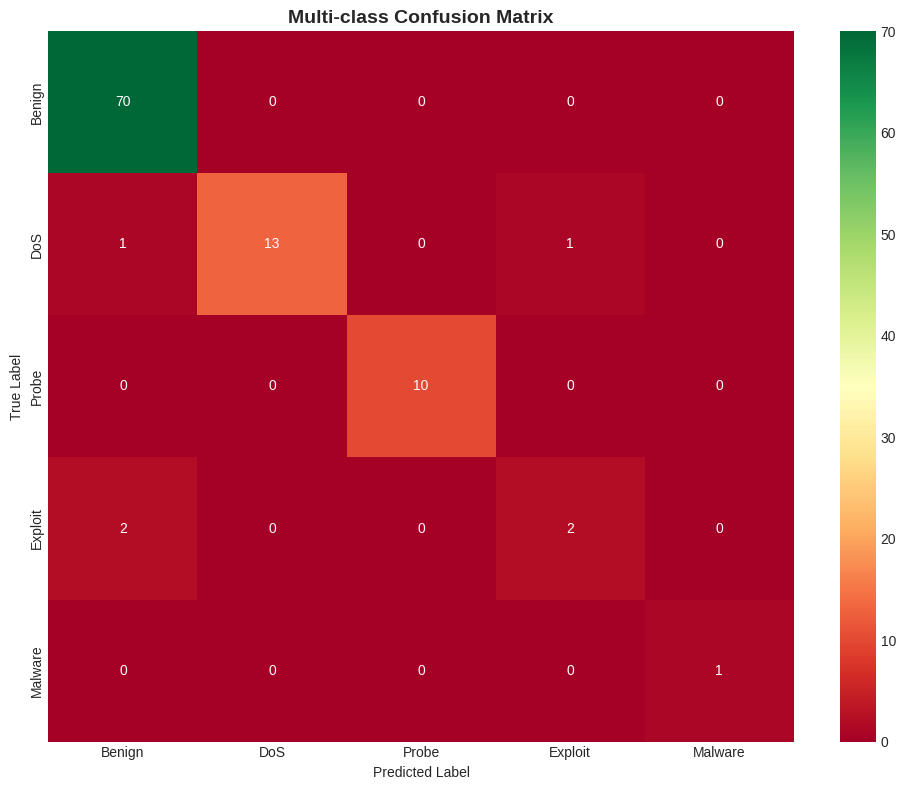


PER-SAMPLE CLASSIFICATION RESULTS

1: Benign
2: Benign
3: Benign
4: Benign
5: DoS
6: Benign
7: Benign
8: DoS
9: Benign -wrong- was DoS
10: Benign
11: Benign
12: Benign
13: Malware
14: Benign
15: Benign
16: Benign
17: Benign
18: Benign
19: Benign
20: Benign
21: Benign
22: Benign
23: Benign
24: Probe
25: Benign
26: Benign
27: Benign
28: Benign
29: DoS
30: Benign
31: Benign
32: Benign
33: Benign
34: Probe
35: DoS
36: Probe
37: Exploit
38: Benign
39: DoS
40: Benign
41: Benign
42: Benign
43: Benign
44: Benign
45: Probe
46: DoS
47: Benign
48: Benign
49: Benign
50: Benign
51: Benign
52: Benign
53: DoS
54: Benign
55: DoS
56: DoS
57: Benign
58: Benign
59: Benign
60: Benign
61: Benign
62: Benign -wrong- was Exploit
63: Benign
64: Benign
65: Exploit
66: Exploit -wrong- was DoS
67: Benign
68: Benign
69: Benign
70: DoS
71: Benign
72: Benign
73: Benign
74: Benign
75: DoS
76: Probe
77: Probe
78: Benign
79: Benign
80: Benign
81: Benign
82: Probe
83: Probe
84: Benign
85: Probe
86: Benign
87: Benign
88

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


def load_model_and_scaler():
    model = load_model('hybrid_model.h5')
    scaler = joblib.load('scaler.pkl')
    print("Loaded: hybrid_model.h5")
    print("Loaded: scaler.pkl")
    return model, scaler


def predict_multiclass(model, X_scaled):
    preds = model.predict(X_scaled, verbose=0)
    multiclass_pred = np.argmax(preds[1], axis=1)
    return multiclass_pred


def plot_multiclass_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title('Multi-class Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def create_performance_table(y_true, y_pred):
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']
    cm = confusion_matrix(y_true, y_pred)

    overall_acc = accuracy_score(y_true, y_pred)
    overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    metrics_data = []
    for i, name in enumerate(class_names):
        if i < len(cm):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            support = cm[i, :].sum()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            metrics_data.append({
                'Class': name,
                'Precision': f'{precision:.4f}',
                'Recall': f'{recall:.4f}',
                'F1-Score': f'{f1:.4f}',
                'Support': support
            })

    df = pd.DataFrame(metrics_data)

    print("\n" + "="*70)
    print("MULTI-CLASS PERFORMANCE METRICS")
    print("="*70)
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Weighted F1-Score: {overall_f1:.4f}\n")
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))
    print()


def display_sample_predictions(y_true, y_pred):
    class_names = ['Benign', 'DoS', 'Probe', 'Exploit', 'Malware']

    print("\n" + "="*70)
    print("PER-SAMPLE CLASSIFICATION RESULTS")
    print("="*70)
    print()

    for i in range(len(y_true)):
        true_class = class_names[y_true[i]]
        pred_class = class_names[y_pred[i]]

        if y_true[i] == y_pred[i]:
            print(f"{i+1}: {pred_class}")
        else:
            print(f"{i+1}: {pred_class} -wrong- was {true_class}")

    print()


def main():
    print("="*70)
    print("MULTI-CLASS CLASSIFICATION TEST")
    print("="*70)

    print("\n[1] Loading model...")
    model, scaler = load_model_and_scaler()

    print("\n[2] Generating test data...")
    X_raw, y = generate_network_flow_data(n_samples=100)

    print("\n[3] Engineering features...")
    X = engineer_features(X_raw)

    print("\n[4] Normalizing...")
    X_scaled = scaler.transform(X)

    print("\n[5] Predicting...")
    y_pred = predict_multiclass(model, X_scaled)

    print("\n[6] Generating results...")
    create_performance_table(y, y_pred)

    print("\n[7] Displaying confusion matrix...")
    plot_multiclass_confusion(y, y_pred)

    display_sample_predictions(y, y_pred)

    print("="*70)
    print("COMPLETE")
    print("="*70)


if __name__ == "__main__":
    main()
